In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Load files

In [2]:
train_files = []
mask_files = glob('./data/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['./data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_17.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_18.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_19.tif']
['./data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960

# split into train test val

In [3]:
def label(mask):
    value = np.max(cv2.imread(mask))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image": train_files,
                   "mask": mask_files,
                  "label":[label(x) for x in mask_files]})

In [4]:
df_train, df_test = train_test_split(df,test_size = 0.25, stratify=df['label'])
df_train, df_val = train_test_split(df_train,test_size = 0.4, stratify=df_train['label'])
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(1767, 3)
(1179, 3)
(983, 3)


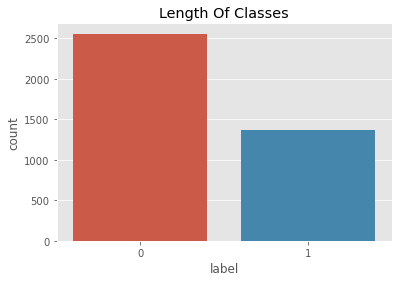

In [5]:
sns.countplot(data=df,x=df['label'])
plt.title('Length Of Classes')
plt.show();

<AxesSubplot:xlabel='label', ylabel='count'>

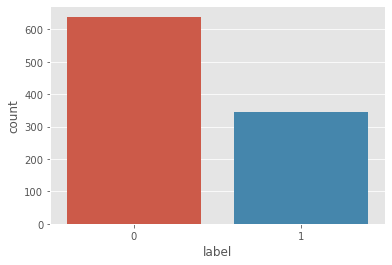

In [6]:
sns.countplot(data=df_test,x=df_test['label'])

<AxesSubplot:xlabel='label', ylabel='count'>

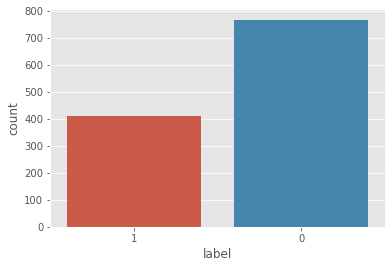

In [7]:
sns.countplot(data=df_val,x=df_val['label'])

# Loading images

In [8]:
train_generator_args = dict(rescale=1. / 255, 
                            rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest',
                           preprocessing_function = preprocess_input)

train_datagen = ImageDataGenerator(**train_generator_args)

In [9]:
train_gen = train_datagen.flow_from_dataframe(
                                            df_train,
                                            x_col = "image",
                                            y_col = 'label',
                                            class_mode = 'binary',
                                            color_mode = "rgb",
                                            target_size = (256,256),
                                            batch_size = 32,
                                            save_to_dir = None,
                                            save_prefix  = "image")

Found 1767 validated image filenames belonging to 2 classes.


In [10]:
img_gen = ImageDataGenerator(rescale=1. / 255, 
                             preprocessing_function = preprocess_input)

val_gen = img_gen.flow_from_dataframe(
                                        df_val,
                                        x_col = "image",
                                        y_col = 'label',
                                        class_mode = 'binary',
                                        color_mode = "rgb",
                                        target_size = (256,256),
                                        batch_size = 32,
                                        save_to_dir = None,
                                        save_prefix  = "image",
                                        shuffle=False)

test_gen = img_gen.flow_from_dataframe(
                                        df_test,
                                        x_col = "image",
                                        y_col = 'label',
                                        class_mode = 'binary',
                                        color_mode = "rgb",
                                        target_size = (256,256),
                                        batch_size = 32,
                                        save_to_dir = None,
                                        save_prefix  = "image",
                                        shuffle=False)

Found 1179 validated image filenames belonging to 2 classes.
Found 983 validated image filenames belonging to 2 classes.


# Model design

# 4 layer conv

In [24]:
classifier=Sequential([
    
                Conv2D(64,3,activation='relu',input_shape=(256,256,3)),
                BatchNormalization(),              
                MaxPooling2D(3),
    
                Conv2D(128,3,activation='relu'),
                BatchNormalization(),
                MaxPooling2D(3),
    
                Conv2D(128,3,activation='relu'),
                BatchNormalization(),
                MaxPooling2D(3),

                Conv2D(256,3,padding='valid',activation='relu'),
                BatchNormalization(),
                MaxPooling2D(3),

                Flatten(),
    
                Dense(1024,activation='relu'),
                BatchNormalization(),
    
                Dense(256,activation='relu'),
                BatchNormalization(),
    
                Dense(1,activation='sigmoid')
                  
])

In [25]:
classifier.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 batch_normalization_20 (Bat  (None, 254, 254, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 84, 84, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 82, 82, 128)       73856     
                                                                 
 batch_normalization_21 (Bat  (None, 82, 82, 128)      512       
 chNormalization)                                                
                                                      

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', verbose=1, patience=10,min_delta=0.0001, factor=0.2)
checkpointer = ModelCheckpoint('basicCNN' +'.hdf5', verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
callback_list = [reduce_lr, checkpointer, earlystopping]

In [15]:
classifier.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',metrics=['accuracy'])

history = classifier.fit(train_gen,
                    epochs=40, 
                    callbacks=callback_list,
                    validation_data = val_gen)

Epoch 1/40
56/56 [==============================] - ETA: 0s - loss: 0.3139 - accuracy: 0.8676
Epoch 00001: val_loss did not improve from 0.58389
56/56 [==============================] - 94s 2s/step - loss: 0.3139 - accuracy: 0.8676 - val_loss: 0.7964 - val_accuracy: 0.6599 - lr: 0.0010
Epoch 2/40
56/56 [==============================] - ETA: 0s - loss: 0.2891 - accuracy: 0.8812
Epoch 00002: val_loss did not improve from 0.58389
56/56 [==============================] - 97s 2s/step - loss: 0.2891 - accuracy: 0.8812 - val_loss: 0.6317 - val_accuracy: 0.6938 - lr: 0.0010
Epoch 3/40
56/56 [==============================] - ETA: 0s - loss: 0.2413 - accuracy: 0.9061
Epoch 00003: val_loss did not improve from 0.58389
56/56 [==============================] - 95s 2s/step - loss: 0.2413 - accuracy: 0.9061 - val_loss: 0.9116 - val_accuracy: 0.6785 - lr: 0.0010
Epoch 4/40
56/56 [==============================] - ETA: 0s - loss: 0.2296 - accuracy: 0.9083
Epoch 00004: val_loss improved from 0.58389 t

Epoch 29/40
56/56 [==============================] - ETA: 0s - loss: 0.0933 - accuracy: 0.9649
Epoch 00029: val_loss did not improve from 0.16205
56/56 [==============================] - 88s 2s/step - loss: 0.0933 - accuracy: 0.9649 - val_loss: 0.3833 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 30/40
56/56 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 0.9655
Epoch 00030: val_loss did not improve from 0.16205
56/56 [==============================] - 88s 2s/step - loss: 0.0909 - accuracy: 0.9655 - val_loss: 0.2561 - val_accuracy: 0.9211 - lr: 0.0010
Epoch 31/40
56/56 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9723
Epoch 00031: val_loss did not improve from 0.16205
56/56 [==============================] - 88s 2s/step - loss: 0.0742 - accuracy: 0.9723 - val_loss: 0.2474 - val_accuracy: 0.9372 - lr: 0.0010
Epoch 32/40
56/56 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9791
Epoch 00032: val_loss did not improve fro

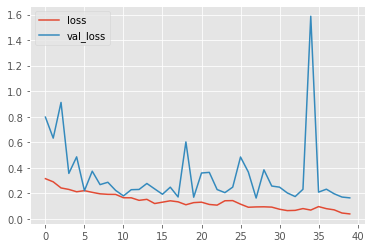

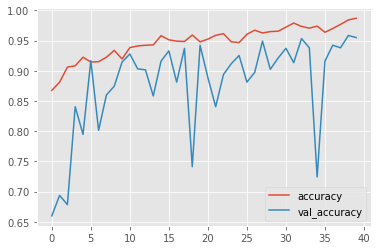

In [16]:
def loss_acc_plot(modelhistory):
    scores = pd.DataFrame(modelhistory.history)
    scores[['loss', 'val_loss']].plot();
    scores[['accuracy', 'val_accuracy']].plot();
    
loss_acc_plot(history)

In [17]:
def test_pred(model):
    y_pred = np.round(model.predict(test_gen))
    y_test = test_gen.classes
    print(classification_report(y_test, y_pred))
    return

test_pred(classifier)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       639
           1       0.98      0.91      0.94       344

    accuracy                           0.96       983
   macro avg       0.97      0.95      0.96       983
weighted avg       0.96      0.96      0.96       983



# model 2: 8 layer conv

In [18]:
classifier2 = Sequential([
    #Conv layer 1, 2
    Conv2D(32, 3, activation='relu', padding='same', input_shape=(256, 256, 3)),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(3),
    
    #Conv layer 3, 4
    Conv2D(64, 3, activation='relu', padding='same'),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(3),
    
    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(3),
    
    Conv2D(256, 3, activation='relu', padding='same'),
    Conv2D(256, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(3),
    
    #Flatten
    Flatten(),
    #full connection
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    #drop out
    Dropout(0.5),
    #sigmoid
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
])

classifier2.summary()

classifier2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', verbose=1, patience=10,min_delta=0.0001, factor=0.2)
checkpointer = ModelCheckpoint('basicCNN_2' +'.hdf5', verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
callback_list = [reduce_lr, checkpointer, earlystopping]

history = classifier2.fit(train_gen,
                    epochs=40, 
                    callbacks=callback_list,
                    validation_data = val_gen)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization_6 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 85, 85, 64)       

Epoch 16/40
56/56 [==============================] - ETA: 0s - loss: 0.3323 - accuracy: 0.9157
Epoch 00016: val_loss did not improve from 0.37656
56/56 [==============================] - 112s 2s/step - loss: 0.3323 - accuracy: 0.9157 - val_loss: 0.4364 - val_accuracy: 0.8872 - lr: 0.0010
Epoch 17/40
56/56 [==============================] - ETA: 0s - loss: 0.3530 - accuracy: 0.8987
Epoch 00017: val_loss did not improve from 0.37656
56/56 [==============================] - 112s 2s/step - loss: 0.3530 - accuracy: 0.8987 - val_loss: 0.3792 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 18/40
56/56 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.9049
Epoch 00018: val_loss improved from 0.37656 to 0.32654, saving model to basicCNN_2.hdf5
56/56 [==============================] - 112s 2s/step - loss: 0.3455 - accuracy: 0.9049 - val_loss: 0.3265 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 19/40
56/56 [==============================] - ETA: 0s - loss: 0.3334 - accuracy: 0.9015
E

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       639
           1       0.85      0.90      0.87       344

    accuracy                           0.91       983
   macro avg       0.90      0.91      0.90       983
weighted avg       0.91      0.91      0.91       983



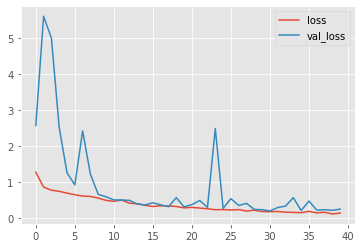

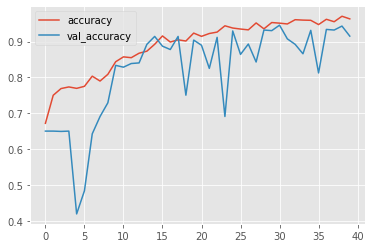

In [19]:
loss_acc_plot(history)
test_pred(classifier2)

# model 3: 3 layer conv

In [22]:
classifier_1 = Sequential([
    
                Conv2D(64,3,activation='relu',input_shape=(256,256,3)),
                BatchNormalization(),              
                MaxPooling2D(3),
    
                Conv2D(128,3,activation='relu'),
                BatchNormalization(),
                MaxPooling2D(3),

                Conv2D(256,3,padding='valid',activation='relu'),
                BatchNormalization(),
                MaxPooling2D(3),

                Flatten(),
    
                Dense(1024,activation='relu'),
                BatchNormalization(),
    
                Dense(256,activation='relu'),
                BatchNormalization(),
    
                Dense(1,activation='sigmoid')
                  
])



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 batch_normalization_15 (Bat  (None, 254, 254, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 84, 84, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 82, 82, 128)       73856     
                                                                 
 batch_normalization_16 (Bat  (None, 82, 82, 128)      512       
 chNormalization)                                                
                                                      

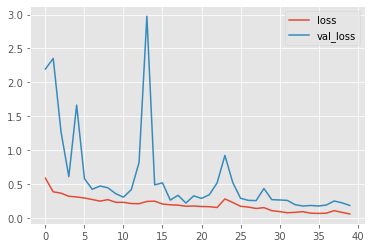

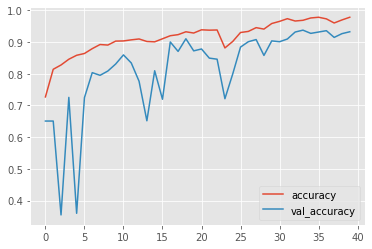

In [23]:
classifier_1.summary()

classifier_1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', verbose=1, patience=10,min_delta=0.0001, factor=0.2)
checkpointer = ModelCheckpoint('basicCNN_1' +'.hdf5', verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
callback_list = [reduce_lr, checkpointer, earlystopping]

history = classifier_1.fit(train_gen,
                    epochs=40, 
                    callbacks=callback_list,
                    validation_data = val_gen)

loss_acc_plot(history)
test_pred(classifier_1)